In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
a_name = 'TCGA-BRCA'
b_name = 'CCLE'

a_path = 'https://webshare.bioinf.unc.edu/public/baprice/Genewise_Cohort_Integration/TCGABRCAxCCLE/tcgabrca_pre-gwci.csv'
b_path = 'https://webshare.bioinf.unc.edu/public/baprice/Genewise_Cohort_Integration/TCGABRCAxCCLE/ccle_pre-gwci.csv'

a_joint_path = './output/gwci_tcgabrca-ccle_tcgabrca-joint.csv'
b_joint_path = './output/gwci_tcgabrca-ccle_ccle-joint.csv'

a_indiv_path = './output/gwci_tcgabrca-ccle_tcgabrca-individual.csv'
b_indiv_path = './output/gwci_tcgabrca-ccle_ccle-individual.csv'

a = pd.read_csv(a_path, index_col=0)
b = pd.read_csv(b_path, index_col=0)
a_joint = pd.read_csv(a_joint_path, index_col=0)
b_joint = pd.read_csv(b_joint_path, index_col=0)
a_indiv = pd.read_csv(a_indiv_path, index_col=0)
b_indiv = pd.read_csv(b_indiv_path, index_col=0)

In [10]:
import pickle

with open('./output/gwci_tcgabrca-ccle_ajive.p', 'rb') as p:
    ajive = pickle.load(p)

## Figure 2A: Variation Explained Plot

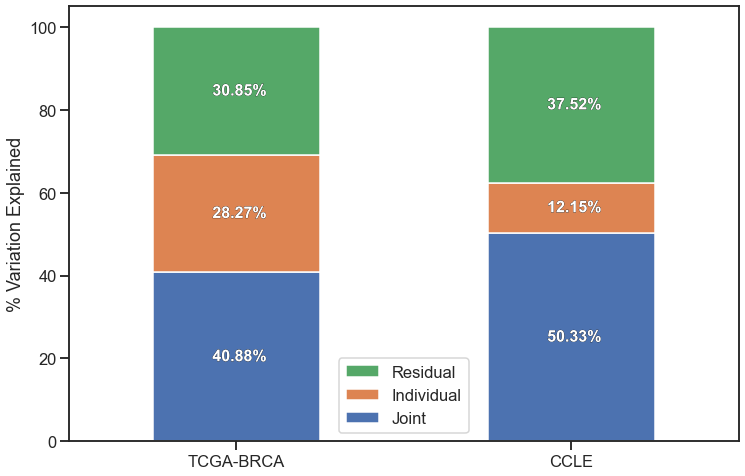

<Figure size 432x288 with 0 Axes>

In [11]:
def getVarianceExplained(original, joint, individual, label):
    from numpy.linalg import norm
    joint_var = norm(joint)**2/norm(original)**2
    individual_var = norm(individual)**2/norm(original)**2
    residual_var = 1-joint_var-individual_var
    return pd.DataFrame([np.round(joint_var*100, 2), np.round(individual_var*100,2), np.round(residual_var*100,2)], index=['Joint','Individual','Residual'], columns=[label])

def plotVarianceExplained(df, figsize=[12,8]):
    import matplotlib.patheffects as PathEffects
    sns.set(context='talk', style='ticks')
    sns.set_style('ticks')
    ax = df.plot.bar(stacked=True, figsize=figsize, table=False, rot='horizontal')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels))
    
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.2f}'  
        label_x = x + width - 0.16  
        label_y = y + height / 2 
        txt = ax.text(label_x, label_y, label_text + '%', ha='right', va='center', fontsize=16, color='white', fontweight='black')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
        
    ax.set_ylabel("% Variation Explained", fontsize=18)
    plt.show()
    
    plt.tight_layout()
       
plt_df = getVarianceExplained(a, a_joint, a_indiv, a_name).join(getVarianceExplained(b, b_joint, b_indiv, b_name)).T
plotVarianceExplained(plt_df)

## Figure 2B

Text(0, 0.5, '$\\frac{Joint\\ Proportion}{Individual\\ Proportion}$')

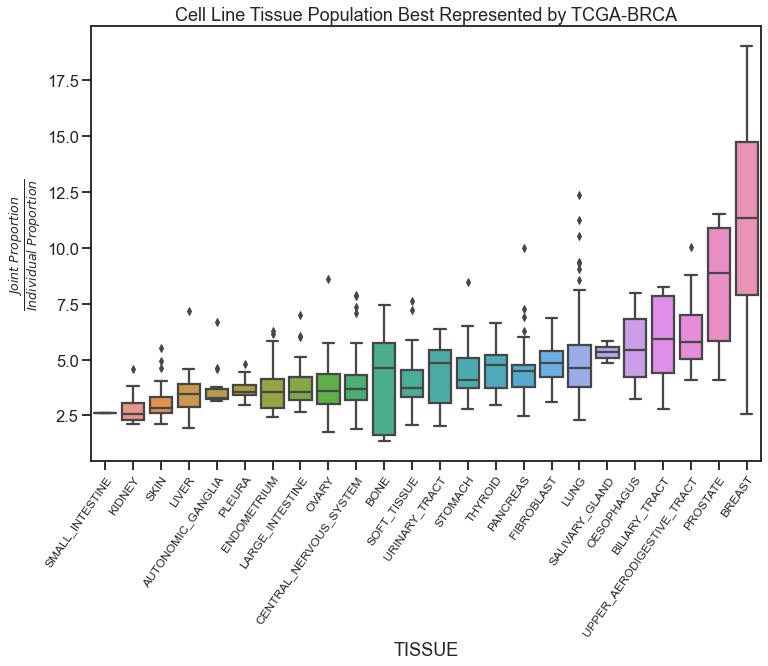

In [18]:
#Unnormalized Scores
tcgabrca_j_unnorm = ajive.blocks['A'].joint.svals()*ajive.blocks['A'].joint.loadings()
tcgabrca_i_unnorm = ajive.blocks['A'].individual.svals()*ajive.blocks['A'].individual.loadings()
ccle_j_unnorm = ajive.blocks['B'].joint.svals()*ajive.blocks['B'].joint.loadings()
ccle_i_unnorm = ajive.blocks['B'].individual.svals()*ajive.blocks['B'].individual.loadings()

#Proportion of Variation
tcgabrca_joint_prop = np.sum(tcgabrca_j_unnorm**2, axis=1)/np.sum(a.T**2, axis=0)
tcgabrca_indiv_prop = np.sum(tcgabrca_i_unnorm**2, axis=1)/np.sum(a.T**2, axis=0)
tcgabrca_prop_df = pd.DataFrame([tcgabrca_joint_prop, tcgabrca_indiv_prop], index=['Joint Proportion','Individual Proportion']).T

ccle_joint_prop = np.sum(ccle_j_unnorm**2, axis=1)/np.sum(b.T**2, axis=0)
ccle_indiv_prop = np.sum(ccle_i_unnorm**2, axis=1)/np.sum(b.T**2, axis=0)
#(Remove Duplicate Cell Lines)
ccle_joint_prop = ccle_joint_prop.drop(ccle_joint_prop[pd.DataFrame(ccle_joint_prop).index.duplicated()].index)
ccle_indiv_prop = ccle_indiv_prop.drop(ccle_indiv_prop[pd.DataFrame(ccle_indiv_prop).index.duplicated()].index)
ccle_prop_df = pd.DataFrame([ccle_joint_prop, ccle_indiv_prop], index=['Joint Proportion','Individual Proportion']).T

#Determine Tissue from cell line ID
ccle_prop_df['TISSUE'] = ccle_prop_df.index.map(lambda i: '_'.join(i.split('_')[1:]))

#Calculate Ratio Metric
ccle_prop_df['%Joint'] = ccle_prop_df['Joint Proportion']*100
ccle_prop_df['%Individual'] = ccle_prop_df['Individual Proportion']*100
ccle_prop_df['Ratio'] = ccle_prop_df.apply(lambda i: i['Joint Proportion']/i['Individual Proportion'], axis=1)

#Plot
tissue_sort = ccle_prop_df.reset_index().groupby('TISSUE').mean().sort_values('Ratio').index.tolist()
plt.figure(figsize=[12,8], facecolor='w')
sns.boxplot(data=ccle_prop_df, x='TISSUE', y='Ratio', order=tissue_sort)
plt.xticks(size=12, rotation=55, ha='right', rotation_mode="anchor");
plt.title('Cell Line Tissue Population Best Represented by TCGA-BRCA')
plt.ylabel(r'$\frac{Joint\ Proportion}{Individual\ Proportion}$')


# Joint Statistics

In [19]:
def distance(x1, y1, a=-1, b=1, c=0):  
    return abs((a * x1 + b * y1 + c)) / (np.sqrt(a * a + b * b)) 

def joint_statistics(joint, individual):
    s = 0.05
    return np.var(joint, axis=1).clip(lower=s)-(np.var(individual, axis=1).clip(lower=s))

def permute_expected_statistics(joint, individual, n_perm=20):
    joined = joint.join(individual, lsuffix='_J', rsuffix='_I')
    perms = []
    sig_counts = []
    for p in range(n_perm):
        col_perm = np.random.permutation(joined.columns.tolist())
        j_perm = joined[col_perm[:len(col_perm)//2]]
        i_perm = joined[col_perm[len(col_perm)//2:]]
        exp_stat = np.sort(joint_statistics(j_perm, i_perm))[::-1]
        perms.append(exp_stat)
    
    return pd.DataFrame(perms)

In [20]:
a_obs_j = pd.Series(joint_statistics(a_joint, a_indiv))
a_expect_j_perms = permute_expected_statistics(a_joint, a_indiv, n_perm=200)
a_expect_j = pd.DataFrame(a_expect_j_perms).mean()
a_expect_j.index = a_joint.index
a_obs_j_sort = a_obs_j.sort_values(ascending=False)
a_stat_df = pd.DataFrame([np.sort(a_obs_j)[::-1], a_expect_j], index=['Observed','Expected'], columns=a_obs_j_sort.index).T

b_obs_j = pd.Series(joint_statistics(b_joint, b_indiv))
b_obs_j_sort = b_obs_j.sort_values(ascending=False)
b_expect_j_perms = permute_expected_statistics(b_joint, b_indiv, n_perm=200)
b_expect_j = pd.DataFrame(b_expect_j_perms).mean()
b_expect_j.index = b_joint.index
b_stat_df = pd.DataFrame([np.sort(b_obs_j)[::-1], b_expect_j], index=['Observed','Expected'], columns=b_obs_j_sort.index).T

jstats_df = a_stat_df.join(b_stat_df, lsuffix='_'+str(a_name), rsuffix='_'+str(b_name))

In [21]:
jstats_df.head()

,Observed_TCGA-BRCA,Expected_TCGA-BRCA,Observed_CCLE,Expected_CCLE
AL589842.1,4.393258,0.501579,2.126029,0.094742
VGLL1,3.478945,0.399300,5.472110,0.337364
TFF3,3.362353,0.352352,4.687231,0.272666
KRT16,3.064560,0.325356,5.538616,0.347299
RP11-63M22.2,3.011258,0.306771,0.852571,0.024893


Text(0, 0.5, 'Observed CCLE Joint Statistic')

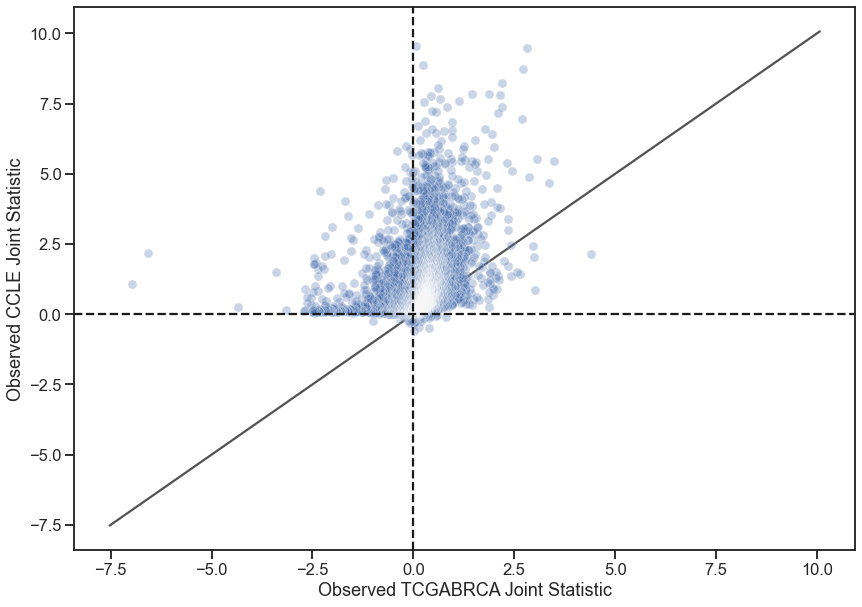

In [29]:
import matplotlib.patches as mpatches

sns.set_context('talk')
plt.figure(figsize=[14,10])
sns.set_context('talk')
sns.set_palette('deep')

ax = sns.scatterplot(data=jstats_df, x='Observed_TCGA-BRCA', y='Observed_CCLE', alpha=0.3)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Observed TCGABRCA Joint Statistic')
plt.ylabel('Observed CCLE Joint Statistic')